In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import StratifiedKFold
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from config.config import Config
from models.binary_cnn.binary_cnn import ImprovedBinaryCNN, BinaryImageDataset, evaluate

In [2]:
log_file = Config.project_root / "notebooks" / "binary_cnn_inference.log"
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for more detailed logs
    format="%(asctime)s %(levelname)s: %(message)s",
    handlers=[
        logging.FileHandler(log_file, mode="a"),  # Append mode
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

In [3]:
def imshow(img_tensor, title=None):
    """Convert a tensor to a NumPy image (after unnormalizing) and display it."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

In [4]:

def run_kfold_inference(target_class="fox", k_folds=5, num_samples_to_visualize=8):
    """
    Evaluate the single saved model on the test dataset using k-fold testing.
    For each fold, metrics (loss and accuracy) are computed and aggregated.
    Additionally, sample predictions from one fold are visualized.
    """
    # Define the inference transform (same as training/validation)
    inference_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load the full test dataset for the target class
    test_dir = Config.DATA_DIR / target_class / "test"
    logger.info(f"Loading test dataset from {test_dir}")
    full_test_dataset = BinaryImageDataset(test_dir, transform=inference_transform)
    total_samples = len(full_test_dataset)
    logger.info(f"Total test samples loaded: {total_samples}")
    
    # Extract labels for stratification
    all_labels = np.array([label.item() for _, label in full_test_dataset])
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=Config.RANDOM_SEED)
    
    fold_results = []
    fold_idx = 1

    # Load the model (single model for all folds)
    model = ImprovedBinaryCNN().to(Config.device)
    model_weight_file = Config.WEIGHTS_DIR / f"{target_class}_simple_model.pth"  # Update filename if needed
    logger.info(f"Loading model weights from {model_weight_file}")
    model.load_state_dict(torch.load(model_weight_file, map_location=Config.device))
    model.eval()
    logger.info("Model loaded and set to evaluation mode.")
    
    # Loss function for evaluation
    criterion = nn.BCEWithLogitsLoss()
    
    # Evaluate each fold
    for _, fold_test_idx in skf.split(np.zeros(total_samples), all_labels):
        # Create DataLoader for this fold's test indices
        fold_subset = Subset(full_test_dataset, fold_test_idx)
        fold_loader = DataLoader(fold_subset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.num_workers)
        
        fold_loss, fold_acc = evaluate(model, fold_loader, criterion, Config.device)
        logger.info(f"Fold {fold_idx}: Loss = {fold_loss:.4f}, Accuracy = {fold_acc:.4f}")
        fold_results.append((fold_loss, fold_acc))
        fold_idx += 1

    # Plot k-fold evaluation metrics
    folds = list(range(1, k_folds+1))
    losses = [res[0] for res in fold_results]
    accuracies = [res[1] for res in fold_results]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(folds, losses, color='salmon')
    plt.xlabel("Fold")
    plt.ylabel("Loss")
    plt.title("Test Loss per Fold")
    
    plt.subplot(1, 2, 2)
    plt.bar(folds, accuracies, color='skyblue')
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy per Fold")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # OPTIONAL: Visualize sample predictions from the first fold
    # (or any fold of your choice)
    first_fold_idx = next(skf.split(np.zeros(total_samples), all_labels))[1]
    # Randomly sample indices from the first fold
    sampled_indices = random.sample(list(first_fold_idx), min(num_samples_to_visualize * 2, len(first_fold_idx)))
    logger.info(f"Visualizing {len(sampled_indices)} samples from the first fold for inference.")
    
    subset_dataset = Subset(full_test_dataset, sampled_indices)
    subset_loader = DataLoader(subset_dataset, batch_size=len(sampled_indices), shuffle=False)
    
    dataiter = iter(subset_loader)
    images, labels = next(dataiter)
    images, labels = images.to(Config.device), labels.to(Config.device)
    
    with torch.no_grad():
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).float()
    
    total_images = images.size(0)
    num_cols = 4
    num_rows = int(np.ceil(total_images / num_cols))
    
    plt.figure(figsize=(num_cols * 3, num_rows * 3))
    for idx in range(total_images):
        plt.subplot(num_rows, num_cols, idx + 1)
        true_label = int(labels[idx].item())
        pred_label = int(preds[idx].item())
        label_str = "Positive" if true_label == 1 else "Negative"
        title = f"True: {true_label}\nPred: {pred_label}"
        imshow(images[idx], title=title)
    plt.tight_layout()
    plt.show()
    logger.info("K-fold inference and visualization completed.")


2025-02-01 00:31:16,756 INFO: Loading test dataset from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/data/resized_and_split/fox/test
2025-02-01 00:31:16,760 INFO: Total test samples loaded: 1300
2025-02-01 00:31:18,103 INFO: Loading model weights from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/weights/fox_simple_model.pth
2025-02-01 00:31:18,107 INFO: Model loaded and set to evaluation mode.
2025-02-01 00:31:18,787 INFO: Fold 1: Loss = 0.4653, Accuracy = 0.7654
2025-02-01 00:31:19,446 INFO: Fold 2: Loss = 0.4832, Accuracy = 0.7654
2025-02-01 00:31:20,022 INFO: Fold 3: Loss = 0.4392, Accuracy = 0.8192
2025-02-01 00:31:20,590 INFO: Fold 4: Loss = 0.4644, Accuracy = 0.7923
2025-02-01 00:31:21,234 INFO: Fold 5: Loss = 0.4880, Accuracy = 0.7731


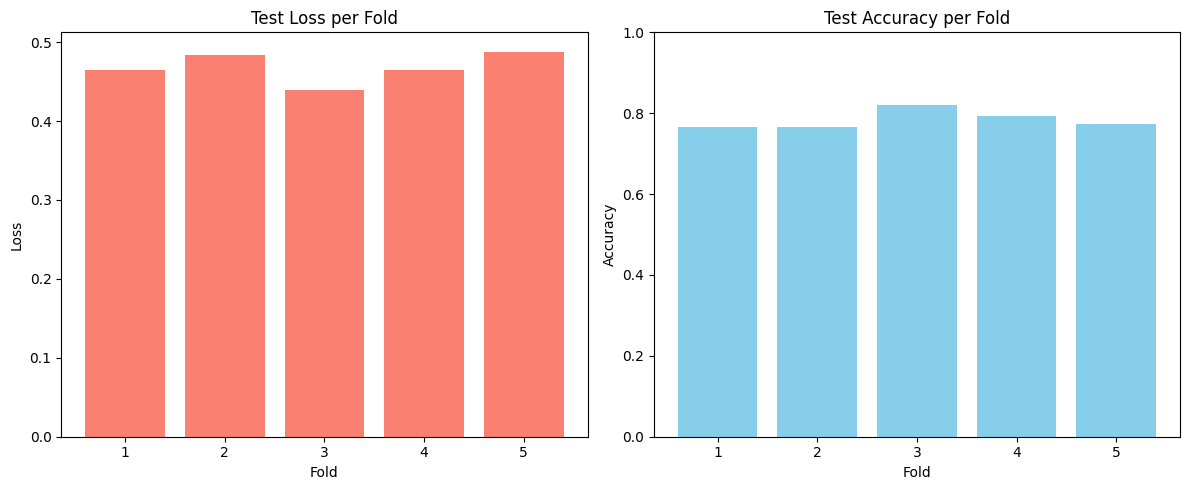

2025-02-01 00:31:21,396 INFO: Visualizing 16 samples from the first fold for inference.


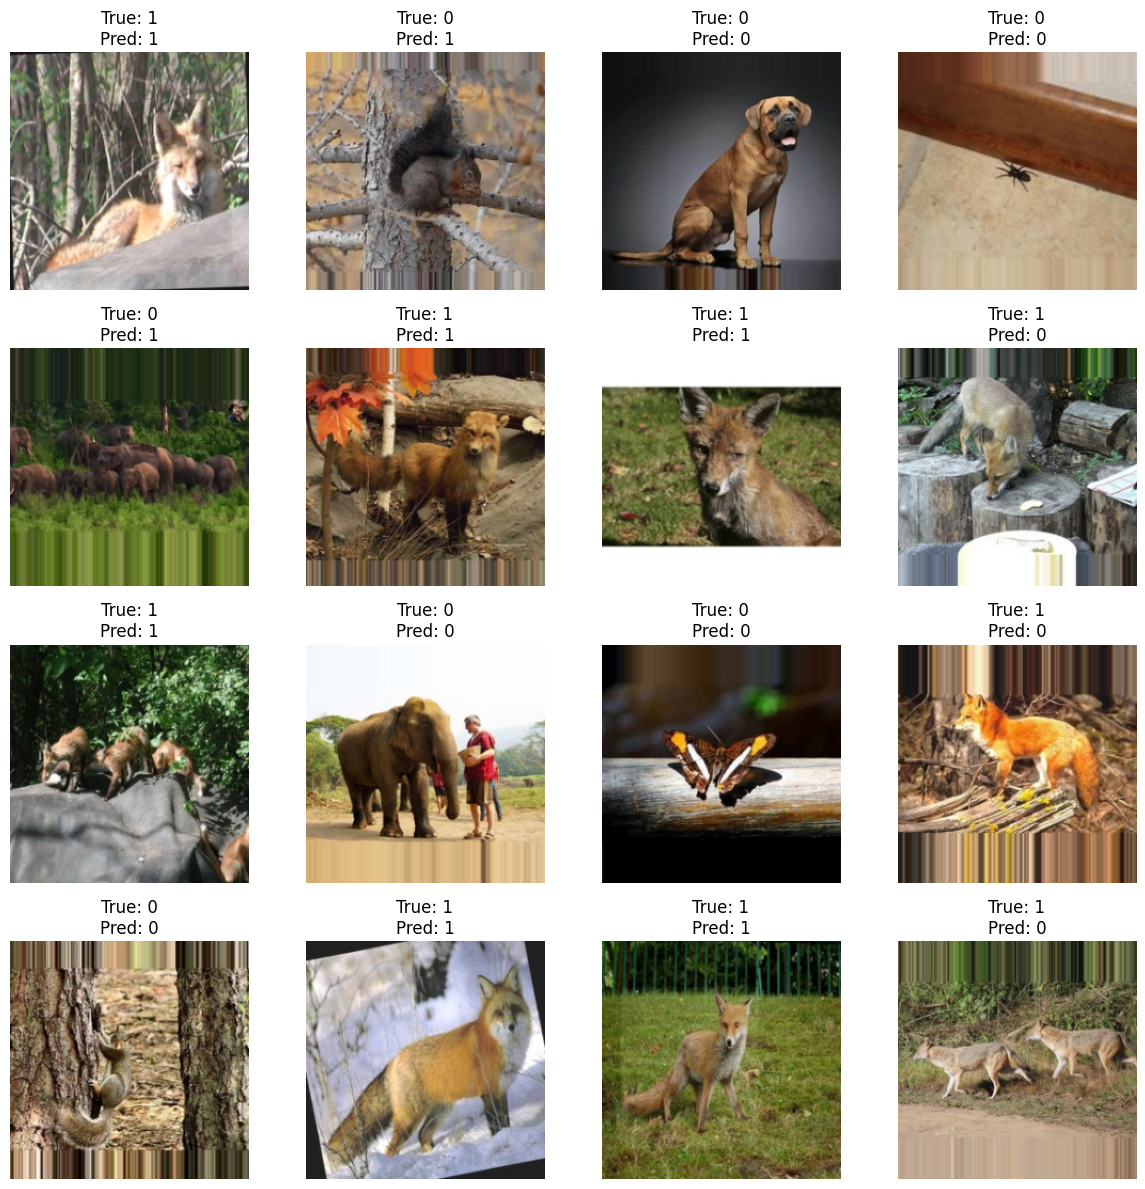

2025-02-01 00:31:21,969 INFO: K-fold inference and visualization completed.


In [5]:
run_kfold_inference(target_class="fox", k_folds=5, num_samples_to_visualize=8)


2025-02-01 00:31:53,068 INFO: Loading test dataset from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/data/resized_and_split/elephant/test
2025-02-01 00:31:53,072 INFO: Total test samples loaded: 2408
2025-02-01 00:31:56,074 INFO: Loading model weights from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/weights/elephant_simple_model.pth
2025-02-01 00:31:56,077 INFO: Model loaded and set to evaluation mode.
2025-02-01 00:31:56,862 INFO: Fold 1: Loss = 0.3580, Accuracy = 0.8672
2025-02-01 00:31:57,706 INFO: Fold 2: Loss = 0.4085, Accuracy = 0.8382
2025-02-01 00:31:58,455 INFO: Fold 3: Loss = 0.4020, Accuracy = 0.8320
2025-02-01 00:31:59,219 INFO: Fold 4: Loss = 0.3738, Accuracy = 0.8358
2025-02-01 00:31:59,897 INFO: Fold 5: Loss = 0.3889, Accuracy = 0.8524


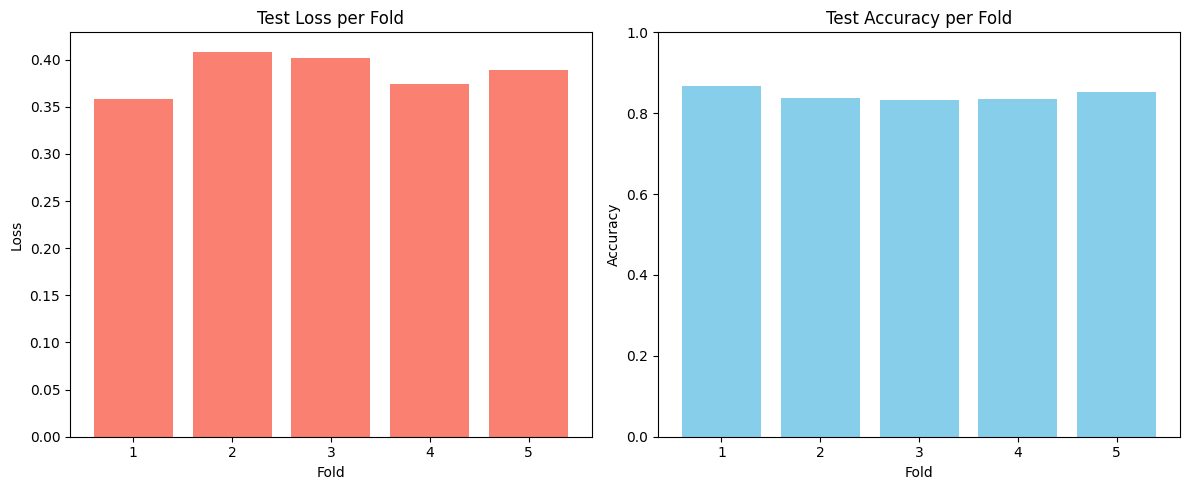

2025-02-01 00:32:00,055 INFO: Visualizing 16 samples from the first fold for inference.


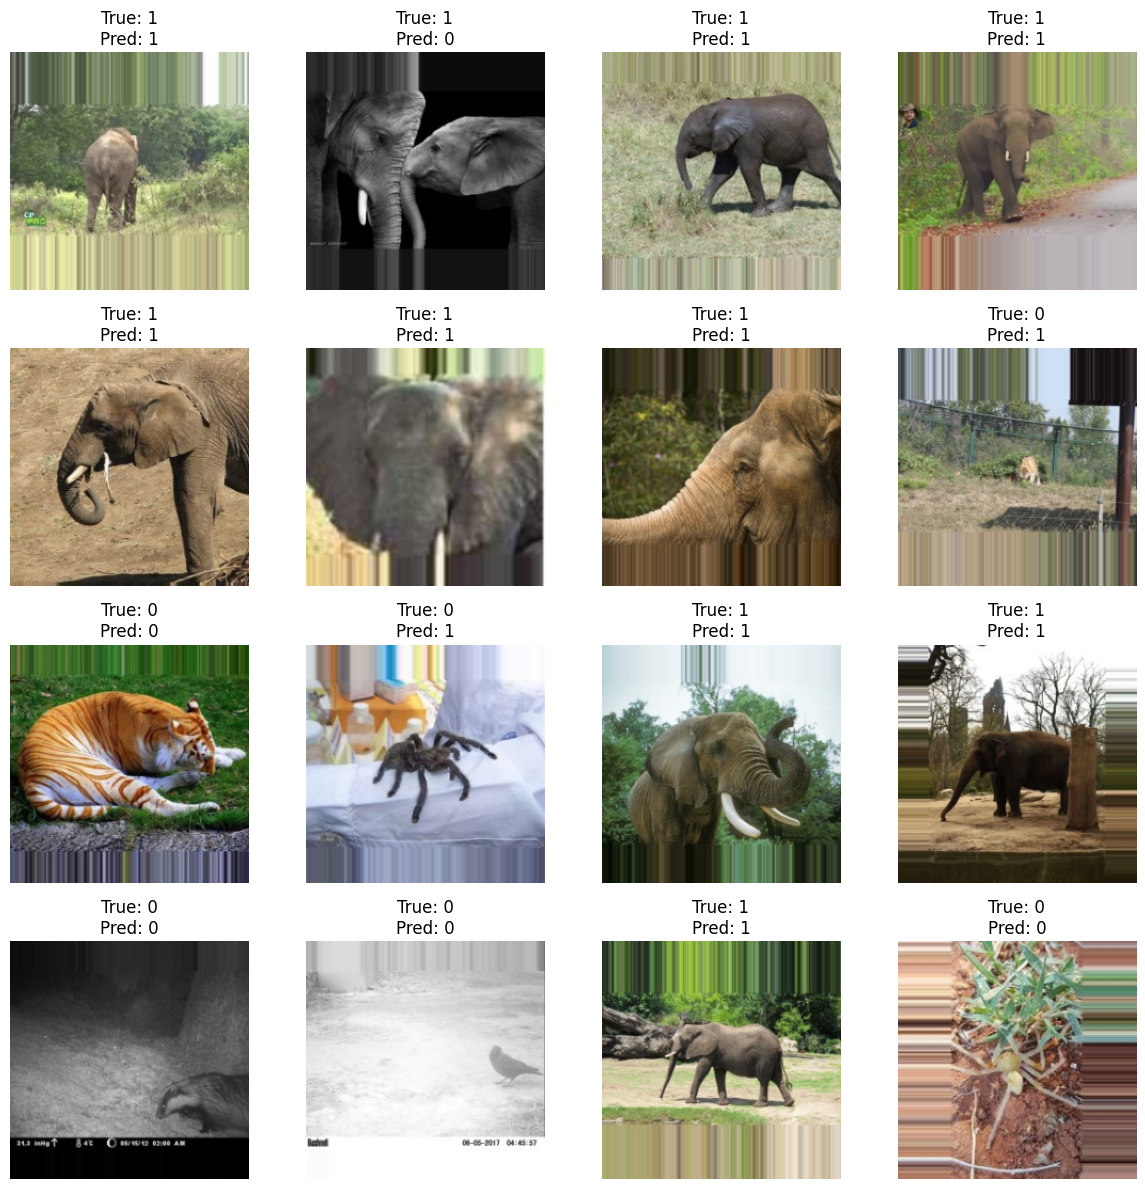

2025-02-01 00:32:00,497 INFO: K-fold inference and visualization completed.


In [6]:
run_kfold_inference(target_class="elephant", k_folds=5, num_samples_to_visualize=8)


2025-02-01 00:32:23,316 INFO: Loading test dataset from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/data/resized_and_split/tiger/test
2025-02-01 00:32:23,319 INFO: Total test samples loaded: 1396
2025-02-01 00:32:25,222 INFO: Loading model weights from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/weights/tiger_simple_model.pth
2025-02-01 00:32:25,225 INFO: Model loaded and set to evaluation mode.
2025-02-01 00:32:25,932 INFO: Fold 1: Loss = 0.3631, Accuracy = 0.8393
2025-02-01 00:32:26,546 INFO: Fold 2: Loss = 0.3713, Accuracy = 0.8602
2025-02-01 00:32:27,115 INFO: Fold 3: Loss = 0.4008, Accuracy = 0.8172
2025-02-01 00:32:27,687 INFO: Fold 4: Loss = 0.3579, Accuracy = 0.8602
2025-02-01 00:32:28,284 INFO: Fold 5: Loss = 0.3935, Accuracy = 0.8351


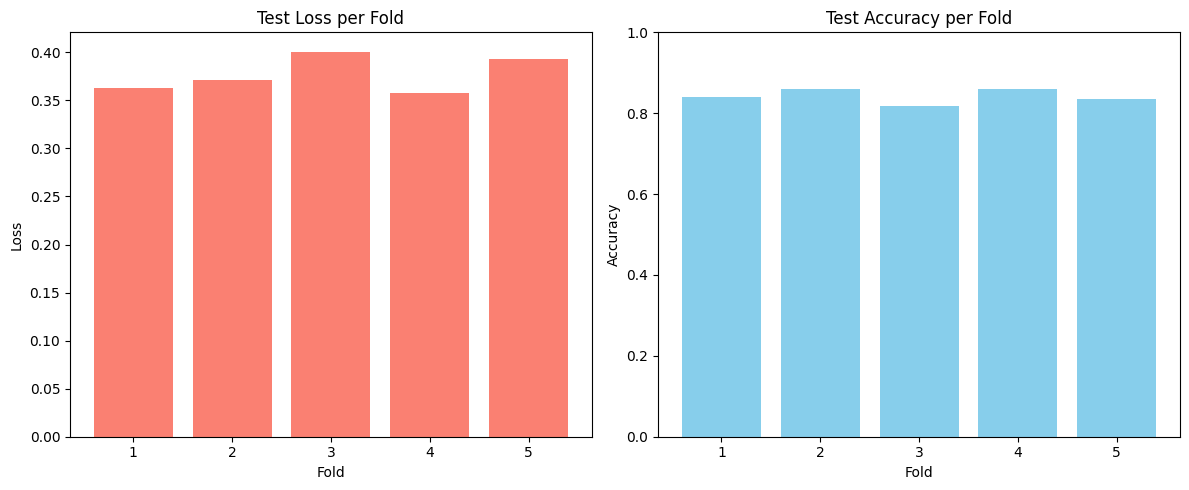

2025-02-01 00:32:28,440 INFO: Visualizing 16 samples from the first fold for inference.


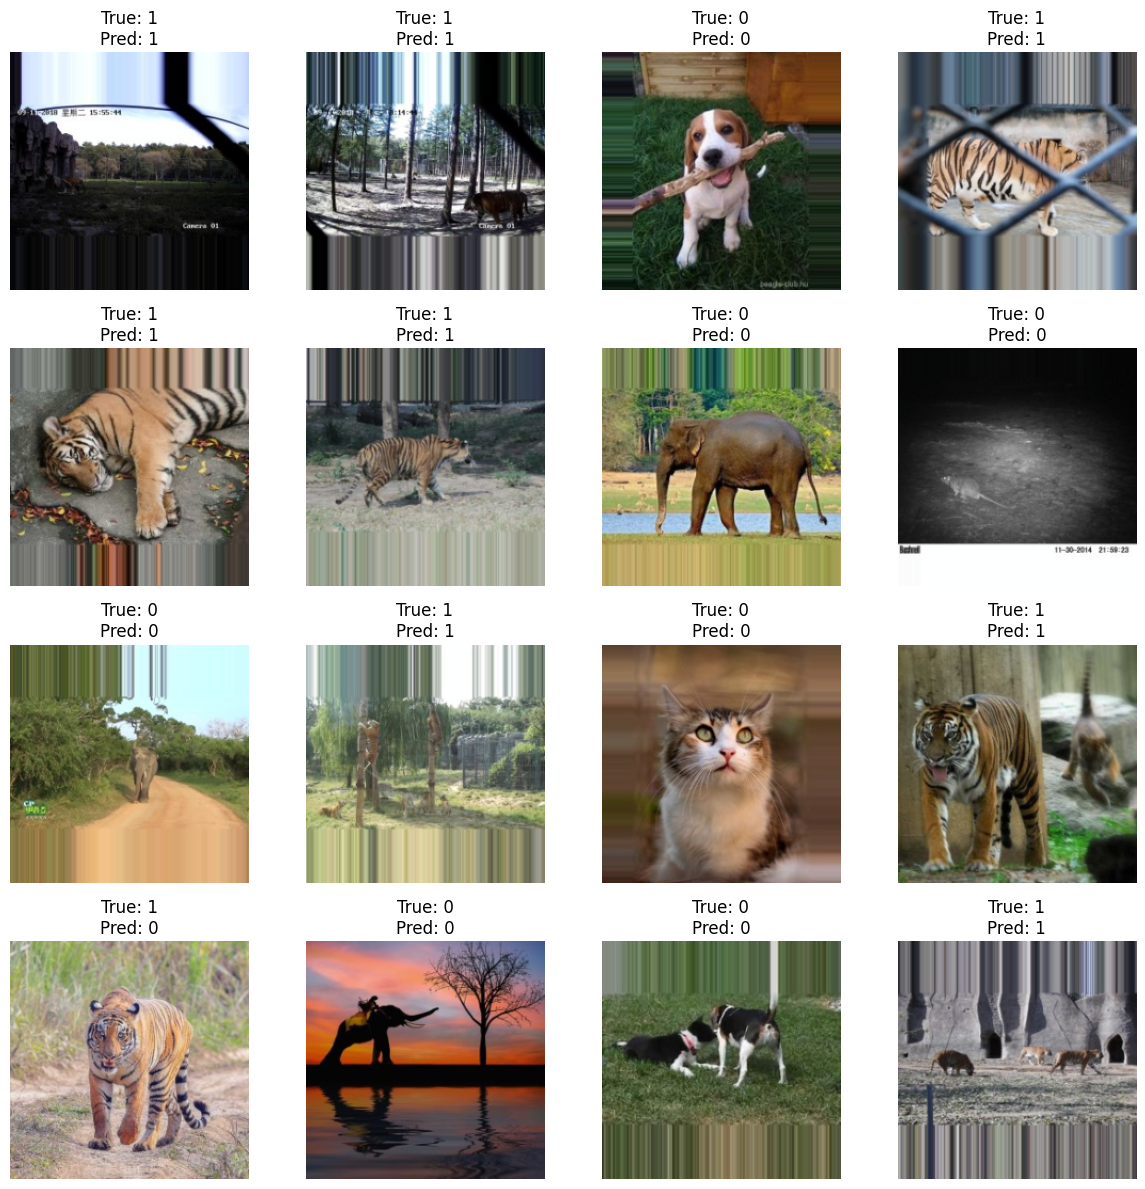

2025-02-01 00:32:29,159 INFO: K-fold inference and visualization completed.


In [7]:
run_kfold_inference(target_class="tiger", k_folds=5, num_samples_to_visualize=8)
